In [ ]:
!pip install tensorflow_addons

In [ ]:
import cv2
import numpy as np
import os
from zipfile import ZipFile
import tensorflow as tf
import keras
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
print(tf.__version__)
print(keras.__version__)

2.5.0
2.5.0


In [ ]:
class PreProcessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect
        # ratio
        return cv2.resize(image, (self.width, self.height),
                          interpolation=self.inter)

In [ ]:
class DatasetLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an
        # empty list
        if preprocessors == None:
            
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming
            # that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg
            image = cv2.imread(imagePath)
            imagePath = os.path.normpath(imagePath)
            label = imagePath.split("/")[-2]

            # check to see if our preprocessors are not None
            if self.preprocessors is not None:
                # loop over the preprocessors and apply each to
                # the image
                for p in self.preprocessors:
                    image = p.preprocess(image)
            data.append(image)
            labels.append(label)

            if verbose>0 and i>0 and (i + 1)%verbose==0:
                print("[INFO] processed {}/{}".format(i + 1,
                                                      len(imagePaths)))
        # treat our processed image as a "feature vector"
        # by updating the data list followed by the labels        
        return (np.array(data), np.array(labels))

In [ ]:
# In the next three cells we get the dataset from Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dvnielrys","key":"22e88ebec19150464def521ad3a63d68"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d chetankv/dogs-cats-images

dogs-cats-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Once we have the dataset from Kaggle as a zip file
# we extract it
file_name = "dogs-cats-images.zip"

with ZipFile(file_name, "r") as zip:
    zip.extractall()
    print("Done")

Done


In [ ]:
# Get the paths of ALL the images in the training set
impaths_train = []
impaths_test = []

for root, dirs, files in os.walk("/content/dataset/training_set"):
    for file in files:
        if file.endswith(".jpg"):
             impaths_train.append(os.path.join(root, file))

for root, dirs, files in os.walk("/content/dataset/test_set"):
    for file in files:
        if file.endswith(".jpg"):
             impaths_test.append(os.path.join(root, file))

In [ ]:
# Define our preprocessor for the training set
height, width = 32, 32
prep = PreProcessor(height, width)
#Load de dataset
load_data = DatasetLoader([prep])
print("Processing Training data...")
data_train = load_data.load(impaths_train, verbose=500)
print("Training data ready!\nProcessing Test data...")
data_test = load_data.load(impaths_test, verbose=500)

Processing Training data...
[INFO] processed 500/8000
[INFO] processed 1000/8000
[INFO] processed 1500/8000
[INFO] processed 2000/8000
[INFO] processed 2500/8000
[INFO] processed 3000/8000
[INFO] processed 3500/8000
[INFO] processed 4000/8000
[INFO] processed 4500/8000
[INFO] processed 5000/8000
[INFO] processed 5500/8000
[INFO] processed 6000/8000
[INFO] processed 6500/8000
[INFO] processed 7000/8000
[INFO] processed 7500/8000
[INFO] processed 8000/8000
Training data ready!
Processing Test data...
[INFO] processed 500/2000
[INFO] processed 1000/2000
[INFO] processed 1500/2000
[INFO] processed 2000/2000


In [ ]:
x_train1, y_train_etiq = data_train
x_test1, y_test_etiq = data_test

print(x_train1.shape, x_test1.shape)

(8000, 32, 32, 3) (2000, 32, 32, 3)


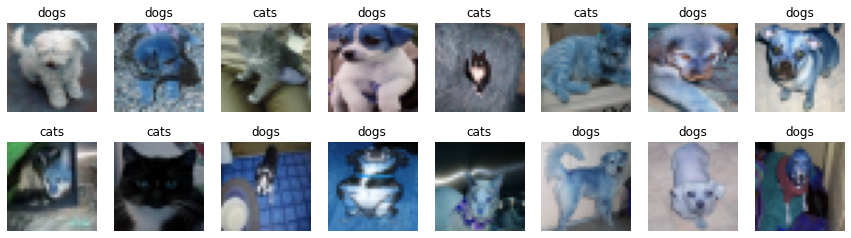

In [ ]:
# show random images from training set
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train_etiq))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train1[random_index, :])
        ax.set_title(y_train_etiq[random_index])
plt.show()

In [ ]:
y_train1 = np.array([0 if  y_train_etiq[i]=='cats' 
                    else 1 for i in 
                    range(len(y_train_etiq))]).reshape((len(y_train_etiq), 1))

y_test1 = np.array([0 if  y_test_etiq[i]=='cats' 
                   else 1 for i in 
                   range(len(y_test_etiq))]).reshape((len(y_test_etiq), 1))
print(y_train1.shape, y_test1.shape)

(8000, 1) (2000, 1)


In [ ]:
# Normalize de inputs
num_classes = 2
x_train = x_train1 / 255. - 0.5
x_test = x_test1 / 255. - 0.5

# convert class labels to one-hot encoded
y_train = tf.keras.utils.to_categorical(y_train1, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test1, num_classes=2)

In [ ]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

In [ ]:
def define_model():

    model = Sequential()
    #Define de model (CNN) arquitecture
    model.add(Conv2D(16, (3, 3), strides=(1, 1), padding="same",  #Convolutional
               input_shape=(height, width, 3)))
    model.add(LeakyReLU(0.1))                                     #Activation
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="same")) #Convolutional
    model.add(LeakyReLU(0.1))                                     #Activation
    model.add(MaxPooling2D(pool_size=(2, 2)))                     #Pooling
    model.add(Dropout(0.25))                                      #Dropout
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding="same")) #Convolutional
    model.add(LeakyReLU(0.1))                                     #Activation
    model.add(MaxPooling2D(pool_size=(2, 2)))                     #Pooling
    model.add(Dropout(0.25))                                      #Dropout
    model.add(Flatten())                                          #Flatten
    model.add(Dense(256))                                         #Dense
    model.add(LeakyReLU(0.1))                                     #Acivation
    model.add(Dropout(0.5))                                       #Dropout
    model.add(Dense(num_classes))                                 #Dense
    model.add(Activation("softmax"))

    return model

In [ ]:
# Summary of the model
s = tf.keras.backend.clear_session()
model = define_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9

In [ ]:
# Let's train the model!!!
init_lr = 5e-3 #initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

s = tf.keras.backend.clear_session() #clear default graph
model = define_model()


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adamax(learning_rate=init_lr), #for SGD
    metrics=['accuracy'] #report the accuracy during the training
)

# Scheduler for learning rate (decay with the epochs)
def lr_scheduler(epoch):
    return init_lr * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

In [ ]:
# we will save model checkpoints to continue training in case of kernel death
model_filename = 'cifar.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
#from keras.models import load_model
#s = reset_tf_session()
#last_finished_epoch = 7
#model = load_model(model_filename.format(last_finished_epoch))

In [ ]:
# Fit model
tqdm_callback = tfa.callbacks.TQDMProgressBar()

model.fit(
    x_train, y_train, # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler),
               LrHistory(),
               tqdm_callback],
    validation_data=(x_test, y_test),
    shuffle=True,
    verbose=0,
    initial_epoch=last_finished_epoch or 0
)

Learning rate: 0.005
Epoch 1/10



Learning rate: 0.0045
Epoch 2/10



Learning rate: 0.00405
Epoch 3/10



Learning rate: 0.003645
Epoch 4/10



Learning rate: 0.0032805
Epoch 5/10



Learning rate: 0.00295245
Epoch 6/10



Learning rate: 0.002657205
Epoch 7/10



Learning rate: 0.0023914846
Epoch 8/10



Learning rate: 0.002152336
Epoch 9/10



Learning rate: 0.0019371024
Epoch 10/10


In [ ]:
# save weights to file
model.save_weights("weights.h5")

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

In [ ]:
# Evaluate the model
# Make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=-1)
y_pred_test_max_probas = np.array([np.max(i) for i in y_pred_test])

In [ ]:
# Evaluate the model on the test data using 'evaluate'
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("test loss, test acc:", results)

Evaluate on test data
63/63 [==============================] - 0s 3ms/step - loss: 0.4421 - accuracy: 0.7985
test loss, test acc: [0.4421084225177765, 0.7985000014305115]


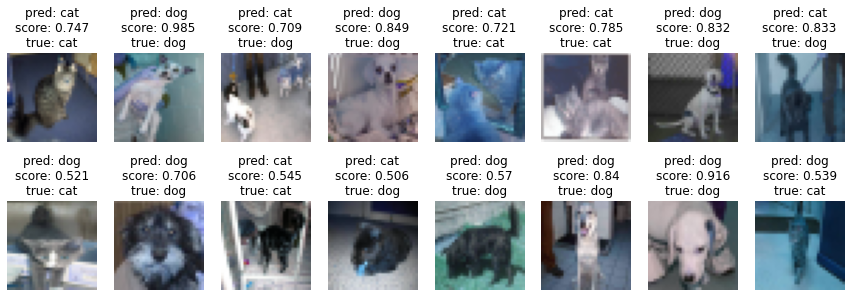

In [ ]:
# inspect preditions
cols = 8
rows = 2
classes = ["cat", "dog"]
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test1[random_index, :])
        pred_label = classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = classes[y_test1[random_index, 0]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()